### Pricing an Asian Option with several variance reduction techniques

This notebook is sample code on using a number of variance reduction techniques to see how accurate an estimate we can get for the price of a discretely monitored Asian Option.

The value of an Asian call option, denoted by $ V(t, S_t) $ is defined as $ \mathbb{E}^\mathbb{Q} \left[ e^{-r(T-t)}\max(\bar{S} - K, 0) \right | \mathcal{F}_t] $

where $\bar{S} := \frac{1}{n} \Sigma_{i=1}^{n} S(t_i)$.

Note that discretely monitoring is easier to work with when simulating as everything is stored discretely, rather than continuously.

For this example, let's define the process such that $S(0) = 50, r = 0.05, \sigma = .03, K = 50,$ and $T = 0.25$. Moreover, we define $m = 90$ and $t_i = iT/m$ for $i = 1, 2, 3, ... , m-1, m$

Thus, this example will price an Asian option whose average value is computed as an arithmetic average of its daily price, likely a closing price tracked at 4 p.m., but it could be anything that the contract terms specify as exotics are not usually on an exchange and are instead traded OTC.

We will explore the following:


1. Standard Monte Carlo Simulation
2. Antithetic Variates
3. Terminal stratification on $S(T)$ with proportional stratification and $d = 10$ equiprobable strata.
4. Post stratification on $\tilde{S}$ where $\tilde{S}$ is the *geometric* mean of $S(t_i)$.
5. Latin Hypercube sampling.

For an exercise in importance sampling, conditional monte carlo, or control variates, see other code samples.

In [290]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

#Define parameters
T = 0.25
r = 0.05
sigma = 0.3
S0 = 50
K = 50
reps = 10000 #number of monte carlo iterations.
m = 90

#Storage
#Each row is a monte carlo iteration
# each column is an individual time step. I.e. reading left to right on an excel spreadsheet, we track a path
# TODO: Revise this Explanation: we have m+1 time steps. index 0 is t = 0, index 1 is t = T/m, ... index m-1 is (m-1)*T/m, index
#X = np.ndarray(shape = (reps, m))
#S = np.ndarray(shape = (reps, m))
#S[:, 0] = S0
#set seed
np.random.seed(seed=489230)

t = np.arange(start = T/m, stop = T + T/m, step = T/m)
#Sample from the standard normal distribution. Note that we sample 10,0000 x 90 normal random variables. That is, one normal for each step for each monte carlo iteration.
Z = sp.norm.rvs(loc = 0, scale = 1, size = (reps,m))
#W represents the standard Brownian Motion
W = np.cumsum(np.sqrt(T/m) * Z, axis = 1) # standard BM
#X represents the drifted and diffused Brownian Motion, i.e. Wiener Process
##TODO: Check if X is constructed with automatic broadcasting from the LHS onto the RHS dimensions
#If not, consider:
#Should produce an m+1 length vector
# repmat(0:m,reps,1) --> np.tile( np.arange(0, m+1), (reps, 1))
X = (r - sigma**2/2) * T / m * np.tile( np.arange(1, m+1), (reps, 1)) + sigma * W
#X[:,:] = (r - sigma**2/2) * T / 90 * np.repeat(a = np.arange(start = 0, stop = T, step = T/m) , repeats = reps, axis = 1) + sigma * W # BM with drift & diffusion
#Construct the Geometric Brownian Motion
S = S0*np.exp(X) # GBM

# Calculate arithmetic and geometric means
Sbar = np.mean(S, 1)
Stilde = sp.gmean(S, 1)



Let's verify that our simulation made sense by looking at some plots.

Text(0, 0.5, 'Value of BM')

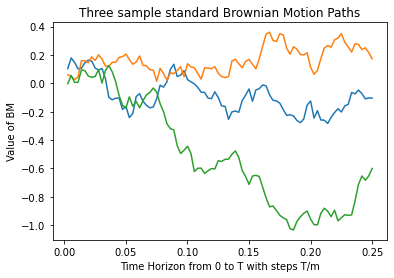

In [291]:
plt.plot(t, W[0, :])
plt.plot(t, W[1, :])
plt.plot(t, W[2, :])
plt.title("Three sample standard Brownian Motion Paths")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value of BM")


Text(0, 0.5, 'Value')

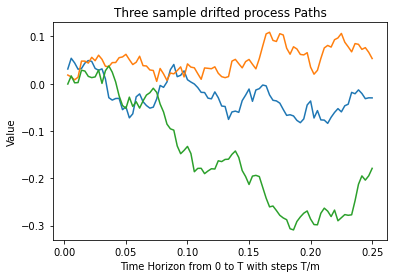

In [292]:
plt.plot(t, X[0, :])
plt.plot(t, X[1, :])
plt.plot(t, X[2, :])
plt.title("Three sample drifted process Paths")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value")

These two plots look good. We expect the plots to look the same since $X$ is just scaled and shifted from $W$. The real magic is the plots of $S$

Text(0, 0.5, 'Value')

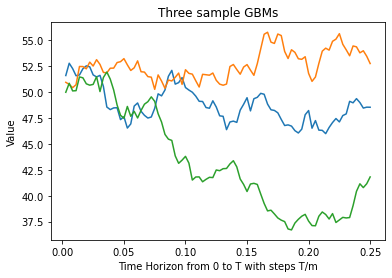

In [293]:
plt.plot(t, S[0, :])
plt.plot(t, S[1, :])
plt.plot(t, S[2, :])
plt.title("Three sample GBMs")
plt.xlabel("Time Horizon from 0 to T with steps T/m")
plt.ylabel("Value")

These plots look good. Before we move forward though, one point of clarification. If we look closely, we see that the plots do not start at the same value, which is nonintuitive.

This is because of how we defined our time axis. If we use $m = 90$ steps, so that each iteration is one day, we will either be excluding the value at $ t = 0 $, or excluding the terminal value at $t = T$. Obviously we do not want to exclude the terminal value when we simulate. That is why we exclude the value at $t = 0$.

For cleaner plots, it is advisable to go up to $m + 1$ individual time values, while keeping the step size the same. See the code cell below to see how the generation is performed.

In [74]:
excluding_t_0 = np.linspace(start = T/m, stop = T, num = m)
including_t_0 = np.linspace(start = 0, stop = T, num = m+1)

Now we continue by computing the price and the corresponding 95% Confidence Interval for standard Monte Carlo Simulation.

In [8]:
# (a) Monte Carlo

# Calculate price estimate and 95% CI
Y = np.exp(-r*T) * np.maximum(Sbar - K, 0)
Ybar_MC = np.mean(Y);
s_MC = np.std(Y);
CI_MC = [Ybar_MC - 1.96*s_MC/np.sqrt(reps), Ybar_MC + 1.96*s_MC/np.sqrt(reps)]
print(f'Part 1: Monte Carlo estimator is {Ybar_MC:.4f} with 95 percent CI is [{CI_MC[0]:.4f}, {CI_MC[1]:.4f}]')

Part 1: Monte Carlo estimator is 1.8246 with 95 percent CI is [1.7710, 1.8783]


2. Antithetic Variates.

Antithetic Variates are quite simple. Suppose random variable $Y$ and random variable ${Y}^\prime$ are identically distributed, but are *not necessarily independent.* This is important as we will see at the end of the calculation.

Then we have:

$\mathbb{E} \left[ \frac{Y+ Y^\prime}{2} \right] = \mathbb{E} \left[ Y  \right]$

That is, if we take 50% of each random variable, we can get the same expectation. In the code below, I refer to this as Y_paired.

When we compute the variance, we observe the following:
$Var \left[ \frac{Y+ Y^\prime}{2} \right] = \frac{1}{4} \left[ Var(Y) + Var(Y^\prime) + 2Cov(Y, Y^\prime)  \right]$

Since $Y$ and ${Y}^\prime$ are identically distributed, as per how we defined the variables, their variance is the same and so we can combine the first two terms. Distributing the constant, we are left with
$Var \left[ \frac{Y+ Y^\prime}{2} \right] = \frac{1}{2} \left( Var(Y) + Cov(Y, Y^\prime) \right)$

Thus, if the variables are independent, we have halved the variance. However, if they are negatively correlated, we have an even greater reduction in variance.

So in our example, how we get negatively correlated variables? It's very easy. Take the first half of our variables $Z$, the independently drawn standard normal variables. Then multiply them by $-1$ and use that set as the second half. Draw 0 is perfectly negatively correlated with draw reps/2, which in this case would be 5000; draw 1 is perfectly negatively correlated with draw 5001, and so on.

To drive this point home, below we also plot two antithetic paths.

Text(0.5, 1.0, 'Two Antithetic Sample Paths')

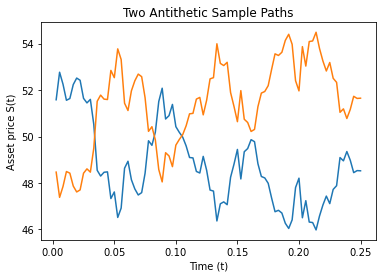

In [294]:
# 2. Antithetic with random walk construction

# Take first 5000 sample paths and create antithetic pairs
Z_anti = np.concatenate((Z[0:reps//2, :], -Z[0:reps//2, :]), axis = 0)
W_anti = np.cumsum(np.sqrt(T/m) * Z_anti, axis = 1)
X_anti = (r - sigma**2/2) * T / m * np.tile( np.arange(1, m+1), (reps, 1)) + sigma * W_anti

S_anti = S0*np.exp(X_anti)


#Plot 2 antithetic sample paths

plt.plot(t, np.transpose(S_anti[[0,5000],:]))
plt.xlabel('Time (t)')
plt.ylabel('Asset price S(t)')
plt.title('Two Antithetic Sample Paths')


In [295]:
# Calculate payoffs and average the antithetic pairs
Sbar_anti = np.mean(S_anti, 1)
Stilde_anti = sp.gmean(S_anti, 1)

Y_anti = np.exp(-r*T) * np.maximum(Sbar_anti - K, 0)
#Y_paired = (Y_anti(1:(reps/2),:) + Y_anti((reps/2+1):reps,:))/2
Y_paired = (Y_anti[0:reps//2] + Y_anti[reps//2:]) / 2.0
# Calculate antithetic estimator, 95% CI, and variance reduction
Ybar_anti = np.mean(Y_paired);
s_anti = np.std(Y_paired);
#Note that change from reps to reps/2 when computing square root. We are working with less samples.
CI_anti = [Ybar_anti - 1.96*s_anti/np.sqrt(reps/2), Ybar_anti + 1.96*s_anti/np.sqrt(reps/2)]
print(f'Part 2: The antithetic estimator is {Ybar_anti:.4f} with 95 percent CI is [{CI_anti[0]:.4f}, {CI_anti[1]:.4f}]')

var_red_anti = 1 - (s_anti**2/(reps/2))/(s_MC**2/reps)
print(f'The estimated variance reduction for antithetic variates is {var_red_anti:.2%}.')

Part 2: The antithetic estimator is 1.8815 with 95 percent CI is [1.8410, 1.9221]
The estimated variance reduction for antithetic variates is 42.75%.


## Terminal Stratification

The general set up is as follows. We want to compute $\mu = \mathbb{E}[Y]$ where $Y$ is a real-valued random variable. Now consider $X$, another random variable that is correlated with Y, and define $A_1, A_2, ... , A_d$ to a disjoint partition of the range of $X$. That is,

$range(X) = \bigcup\limits_{i=1}^d  A_i $

Then, we use the law of total expectation (or law of iterated expectation), which, when applied to a disjoint partition is:

$\mathbb{E}[Y] = \sum\limits_{i=1}^d \mathbb{E}[Y | X \in A_i]P[X \in  A_i] = \sum\limits_{i=1}^{d} \mu_i p_i$

We assume that $p_i$ is known and $\mu_i$ is not.

Finally, we estimate $\mu_i$ with $\hat\mu_i = \frac{1}{n_i} \sum\limits_{j=1}^{n_i} Y_{ij}$ In simple English, this means that for the $i$th strata, we estimate its conditional expectation by taking a sum over the number of observations of $Y_{ij}$ in the $i$ th strata, which is $n_i$, where $Y_{i1}, Y_{i2}, ... , Y_{in_i-1}, Y_{in_i}$ are i.i.d. random variables that have the conditional distribution of $Y$ given that $X$ falls in the $i$ th stratum $A_i$.

The final step is to take the sum of the conditional expectations over all the strat to obtain the estimate for the expectation:
$\hat\mu = \sum\limits_{i=1}^{d} \hat\mu_i p_i = \sum\limits_{i=1}^{d} \left( \frac{1}{n_i} \sum\limits_{j=1}^{n_i} Y_{ij} \right) p_i = \frac{1}{n} \sum\limits_{i=1}^{d} \frac{p_i}{q_i}\sum\limits_{j=1}^{n_i} Y_{ij}$

Note that we define $q_i = \frac{n_i}{n}$ as the proportion of observations from the total that are in $A_i$

So there's a lot of math involved but thankfully the math is all algebra and isn't too much of a pain to implement.

Now, for the purpose of this exercise, we have to change one thing: how we generate sample paths. We are going to terminally stratify our sample paths. This makes sense because we want to control the distribution of where the paths end up. For most options, including some path-dependent options (e.g. barrier options), the terminal value, i.e. the value of the underlying at expiration is what we care about. For Asian options, we care about the average value, but the average value is influenced by the terminal value, and is even more so influenced by the path taken to get to that terminal value.

Thus, since we know we have a geometric brownian motion that must start at 0, and must end at a specific value, we no longer use a random walk construction, but instead a brownian bridge construction. The good news here is that Brownian bridge construction is also exact.

In [256]:
# 3. Stratified Sampling on S(T)

#for testing
#m = 2
#reps = 10
m = 90
reps = 10000


d = 10
#See below for explanation of m+1
W_strat = np.zeros(shape = (reps, m + 1))
# Generate stratified terminal values
#Explanation, for each strata, we create a chunk of random uniform variables. These random uniforms are used specifically for the terminal values. They are transformed
#using an inverse normal distribution
for i in range(0, d):
    #Generate uniforms. Only ONE per each monte carlo path in this strata.
    U  = sp.uniform.rvs(loc = 0, scale = 1, size = (reps//d))
    #Now for our Brownian Bridge Construction, write the values to that index
    start = int((i * reps) / d)
    stop = int( (i+1) * reps / d )
    W_strat[start:stop, -1] = np.dot(np.sqrt(T), sp.norm.ppf( (i+U) / d ) )

We can quickly plot the terminal value of W_strat to confirm that these values are indeed stratified as we expect:

Text(0, 0.5, 'Value')

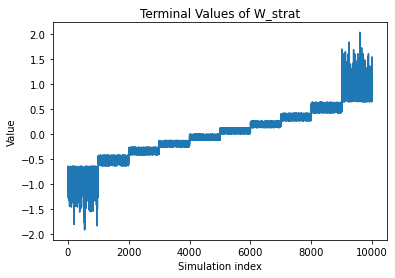

In [257]:
plt.plot(W_strat[:,-1])
plt.title("Terminal Values of W_strat")
plt.xlabel("Simulation index")
plt.ylabel("Value")

In [296]:
# Brownian bridge construction to fill out the sample paths
# As an aside, it's usually better to use Brownian Bridge construction when the number of individual time steps is a power of 2 (2, 4, 8, 16, 32, ... 1024, 2048, ...)
# But it can still be done for irregular amounts like m = 90

#create length m+1 array spaced with T/m increments
times = np.linspace(start = 0, stop = T, num = m+1)
#Sample standard normal random variables for the middle points.
#  That is, not at time t = 0 or time t = T, but everything in between (the middle 89 points of the 91 length vector time)
Z_strat  = sp.norm.rvs(loc = 0, scale = 1, size = (reps,m-1))


#Allocate space

#Brownian Motion always starts at 0 and since we invoke np.zeros we don't need to manually write anything. We can simply begin the for loop.

#Recall the zeroth index of W in the above construction is the time t = T/m
#Since brownian bridge needs a left and right endpoint, we will use the convention that W_strat[0] is the value at time t = 0.as_integer_ratio

#The mth index, which is the final value, is the terminal point, in this construction. This is different from above where we used the m-1th index as the terminal point
#We take the middle 89 points and write it to idxs 1...89. the 89th point is the terminally stratified point

for j in range(1, m): #iterate m-1 times
    # W_strat[:,j] = \
    # (T - times[j])/(T - times[j-1])*W_strat[:,j-1] #ratio from the left point
    # + (times[j] - times[j-1])/(T - times[j-1]) * W_strat[: , -1] #ratio of the rightmost point
    # #these two ratios make up the mean
    # + np.sqrt((T - times[j])*(times[j]-times[j-1])/(T - times[j-1])) * Z_strat[: , j-1] #ratio from Z. This is for the variance portion

    left =  (T - times[j])/(T - times[j-1])*W_strat[:,j-1] #ratio from the left point
    #print(left)
    right = (times[j] - times[j-1])/(T - times[j-1]) * W_strat[: , m] #ratio of the rightmost point
    #print(right)
    var =  np.sqrt((T - times[j])*(times[j]-times[j-1])/(T - times[j-1])) * Z_strat[: , j-1]
    #print(var)
    W_strat[:, j] = left + right + var
# #todo reconcile how times is used below with original construction with T/m
# X_strat = (r-sigma^2/2)*repmat(times,reps,1) + sigma*W_strat; % BM with drift and diffusion

#PYTHON
#X_anti = (r - sigma**2/2) * T / m + sigma * W_anti
#MATLAB
#repmat(0:m,reps,1) CREATES a reps x m+1 matrix where each row is iterating from 0 to m (inclusive on both ends)
#X_anti = (r - sigma^2/2)*T/90*repmat(0:m,reps,1) + sigma*W_anti; 


#MATLAB
#times is 1 x 91 matrix
#repmat broadcasts this single row to an entire matrix
# X_strat = (r-sigma^2/2)*repmat(times,reps,1) + sigma*W_strat; % 

X_strat = (r - sigma**2/2) * np.tile(times, (reps, 1)) + sigma * W_strat
S_strat = S0*np.exp(X_strat) # GBM


Let's perform a sanity check to make sure we haven't lost the plot. If we check every reps/d index (10,000 / 10 = 1,000) in order, do we see a monotonic increase in the terminal value?

Text(0.5, 0, 'The ith bin')

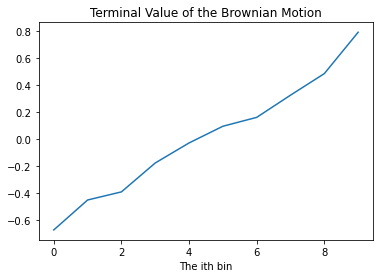

In [271]:
#plt.plot(W_strat[[0,1000,2000,3000,4000,5000,6000,7000,8000,9000], -1])
plt.plot(W_strat[np.arange(start = 0, stop = reps, step = reps//d ), -1])

plt.title("Terminal Value of the Brownian Motion")
plt.xlabel("The ith bin")

Let's also plot 10 terminally stratified paths of $S_t$ (the same paths that result from these terminal values on $W_t$) to once again verify that everything is working normally.

Text(0.5, 1.0, 'Ten Terminally Stratified Sample Paths')

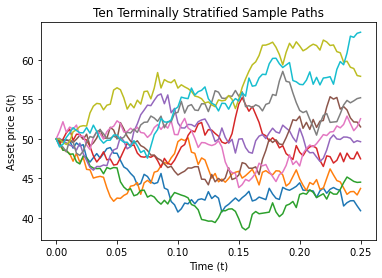

In [298]:
# Plot 10 stratified sample paths from 10 different strata.
plt.plot(np.linspace(0,T,m+1), np.transpose(S_strat[np.arange(start = 0, stop = reps, step = reps//d ), :]))
# plt.plot(np.linspace(0,T,m+1),
#           S_strat(1000*[1:10],:)')
plt.xlabel('Time (t)')
plt.ylabel('Asset price S(t)')
plt.title('Ten Terminally Stratified Sample Paths')

This looks good! Now we can go ahead and compute the statistic we care about (the option payoff)

In [300]:
# Calculate payoffs
#Do not include the 0 index for the sake of consistency here
Sbar_strat = np.mean(S_strat[1:],1)
Y_strat = np.exp(-r*T) * np.maximum(Sbar_strat - K, 0);

# Calculate means and standard deviations within each strata
Y_hat_strat = np.zeros(d)
s_hat_strat = np.zeros(d)
for i in range(0,d):
    #Y_hat_strat[i] = np.mean(Y_strat([1:reps/d] + [i-1]*reps/d))
    Y_hat_strat[i] = np.mean(Y_strat[(i*reps)//d:(i+1)*reps//d])
    #s_hat_strat[i] = np.std(Y_strat([1:reps/d] + (i-1)*reps/d))
    s_hat_strat[i] = np.std(Y_strat[(i*reps)//d:(i+1)*reps//d])

In [302]:
# Calculate stratified sampling estimator, 95% CI, and estimated variance reduction
Ybar_strat = np.mean(Y_hat_strat)
s_strat = np.sqrt(np.mean(s_hat_strat **2))
CI_strat = [Ybar_strat - 1.96*s_strat/np.sqrt(reps), Ybar_strat + 1.96*s_strat/np.sqrt(reps)]
var_red_strat = 1 - (s_strat ** 2) / (s_MC ** 2)

print(f'Part 3: Terminal stratification estimator is {Ybar_strat:.4f} with 95 percent CI [{CI_strat[0]:.4f}, {CI_strat[1]:.4f}]')
print(f'Part 3: The estimated variance reduction for terminal stratification is {var_red_strat:.2%} ')

Part 3: Terminal stratification estimator is 1.8822 with 95 percent CI [1.8499, 1.9146]
Part 3: The estimated variance reduction for terminal stratification is 63.54% 


## Post Stratification

We just concluded our terminal stratification on the individual sample paths. Now let's consider post stratification.

If we can't sample from conditional distributions, whether because it's not possible or difficult to do so, then we can move to post-stratification

We generate $n$ i.i.d. samples ${(X_j, Y_j) : j = 1, ... , n}$

Then define $ N_i = \sum\limits_{j = 1}^{n} \mathbb{I}\{X_j \in A_i\}$ as the number of samples that fall in stratum $i$.
Next, define $ S_i = \sum\limits_{j = 1}^{n} Y_j \mathbb{I}\{X_j \in A_i\}$ as the sum of the observed Y values within stratum $i$.

Then, $\tilde\mu = \frac{S_i}{N_i}$ is the mean of the Y values over those observed in stratum i. Finally, we can estimate $\mu = \mathbb{E}[Y]$ with $\tilde\mu = \sum\limits_{i=1}^{d} \tilde\mu_i p_i$

This is the post-stratification estimator. It can be shown that this estimator has the same variance, asymptotically, as proportional stratification.

We will post-stratify on the geometric average of S. This is because, given that we assume $S$ is a geometric brownian motion, the geometric average of the values is also lognormally distributed with the following distribution:

$\left( \prod\limits_{i=1}^{n} S(t_i) \right)^{1/n} \stackrel{}{\sim} S(0)\exp( (r-\sigma^2/2)\bar{t} + \bar\sigma \mathcal{N}(0, \bar{t}) ) $

where

$\bar{t} = \frac{1}{n} \sum\limits_{i=1}^{n} t_i $, that is, the arithmetic average of the points in time at which the simulation occurs,

and

$\bar\sigma^2 = \frac{\sigma^2}{n^2t} \sum\limits_{i=1}^{n} [2(n-i) + 1]t_i $

In [346]:
#If we include the value of t = 0
#t_bar = (T-0)/2 #the arithmetic average of our time array

#if we don't.T
t_bar = np.average(np.linspace(start = T/m, stop = T, num = m))
#Because we linearly spaced all of our time points, we can simply look at the end points
#This also eliminates floating point round off error

#np.sum((2*(m-[1:m])+1).*t_i))
inner = [(2*(m-i) + 1)*times[i] for i in range (0, m)]
sigma_bar = np.sqrt(sigma**2/(m**2*t_bar)*np.sum(inner))
# Stratify on Stilde (using quantiles of a normal RV)

#d = 10 Number of strata
# norminv((i-1+U)/d);
# sp.norm.ppf( (i+U) / d ) )


#Scale is standard deviation for normal random variables
#Create an array of deciles. These will be the breakpoints to determine how to stratify. Not that we are inclusive of both endpoints for ease of use later on

deciles = S0 * np.exp((r - sigma **2/2)*t_bar + sigma_bar * sp.norm.ppf( q = np.arange(0, 1+1/d, step = 1/d), loc = 0, scale = np.sqrt(t_bar)))
print(deciles)


[ 0.         44.73540553 46.4870924  47.79258945 48.93709625 50.03160721
 51.15059764 52.37551991 53.84638166 55.95482348         inf]


In [365]:
# Post-stratification, i.e., count number of observations in each strata
post_strat_means = np.zeros(d)
post_strat_vars = np.zeros(d)

#Iterate only on the inner values of the decile
for i in range(0, d):
    in_strat_i = (deciles[i] <= Stilde) * (Stilde <= deciles[i+1])
    in_strat_indexes = np.where(in_strat_i)
    post_strat_means[i] = np.mean(np.maximum(Sbar[in_strat_indexes] - K ,0))
    post_strat_vars[i] = np.var(np.exp(-r * T) * np.maximum(Sbar[in_strat_indexes] - K , 0))  

In [366]:
# Calculate post-stratification estimator, 95% CI, and estimated variance reduction
#Note that we did the discounting here, rather than in the loop. This is solely because it leads to less round off error

Ybar_pstrat = np.exp(-r*T)*np.mean(post_strat_means)
# ** Using assumption that variance of post-stratification = variance of  proportional stratification **
# Recall this is correct only asympotically. Otherwise we need to run simulations to estimate the variance
s_pstrat = np.sqrt(np.mean(post_strat_vars))
CI_pstrat = [Ybar_pstrat - 1.96*s_pstrat/np.sqrt(reps), Ybar_pstrat + 1.96*s_pstrat/np.sqrt(reps)]
var_red_pstrat = 1 - s_pstrat**2/s_MC**2

print(f'Part 4: Post stratification estimator is {Ybar_pstrat:.4f} with 95 percent CI [{CI_pstrat[0]:.4f}, {CI_pstrat[1]:.4f}]')
print(f'Part 4: The estimated variance reduction for post stratification is {var_red_pstrat:.2%} ')


Part 4: Post stratification estimator is 1.8842 with 95 percent CI [1.8699, 1.8985]
Part 4: The estimated variance reduction for post stratification is 92.87% 


Note that we achieved significantly more variance reduction with post stratification. Intuitively, this makes sense. We are trying to price an Asian option. This option has payoff directly related to the average arithmetic value of the sample path. When we terminally stratify, we are forcing our simulations to *end* in certain deciles. When we post stratify, we are saying that we don't make any assumptions on how the simulations from the GBM behave, they end up in whatever deciles they naturally will based on the process' drift and diffusion, but we will bin the processes into their respective deciles as it relates to their geometric averages. From there we stratify.

In other words, it makes sense that using the geometric average to inform how we stratify would lead to a greater variance reduction than the terminal value, since more information is capture in the geometric averages. Thus, since we use more information in our variance reduction technique, we eliminate more variance.

I would not be surprised if, for options whose payoffs are based solely on terminal values, we don't see this same degree of improvement.


## Latin Hypercube Sampling

LHS is a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. Stratifying over multiple dimensions becomes impractical due to the curse of dimensionality. LHS is a general-purpose alternative that usually gives useful but not spectacular purposes. It's included here simply for reference and comparison purposes, but is generally not the technique of choice.